In [1]:
from  google.colab  import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
import pandas as pd
data_columns=["target", "ids", "date", "flag", "user", "text"]
data=pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1",names=data_columns)

In [5]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
data.drop(['ids','date','flag','user'],axis=1,inplace=True)
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
label_to_sentiment={0:"NEGATIVE",2:"NEUTRAL",4:"POSITIVE"}

def label_decoder(label):
    return label_to_sentiment[label]
  
data.target=data.target.apply(lambda x: label_decoder(x))
data.head()

,target,text
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,is upset that he can't update his Facebook by ...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,my whole body feels itchy and like its on fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all...."


In [8]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import re
def preprocess(text, stem=False):
  text=re.sub(text_cleaning_re," ",str(text).lower()).strip()
  tokens=[]
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
data.text=data.text.apply(lambda x: preprocess(x))

In [11]:
data.head()

,target,text
0,NEGATIVE,awww bummer shoulda got david carr third day
1,NEGATIVE,upset update facebook texting might cry result...
2,NEGATIVE,dived many times ball managed save 50 rest go ...
3,NEGATIVE,whole body feels itchy like fire
4,NEGATIVE,behaving mad see


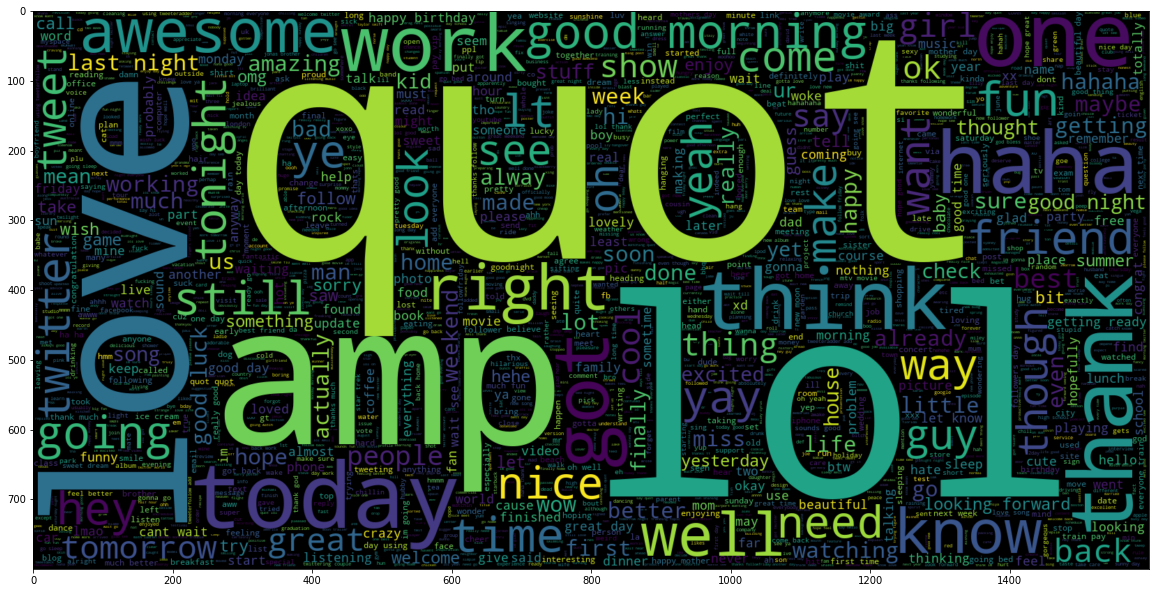

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.target == 'POSITIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

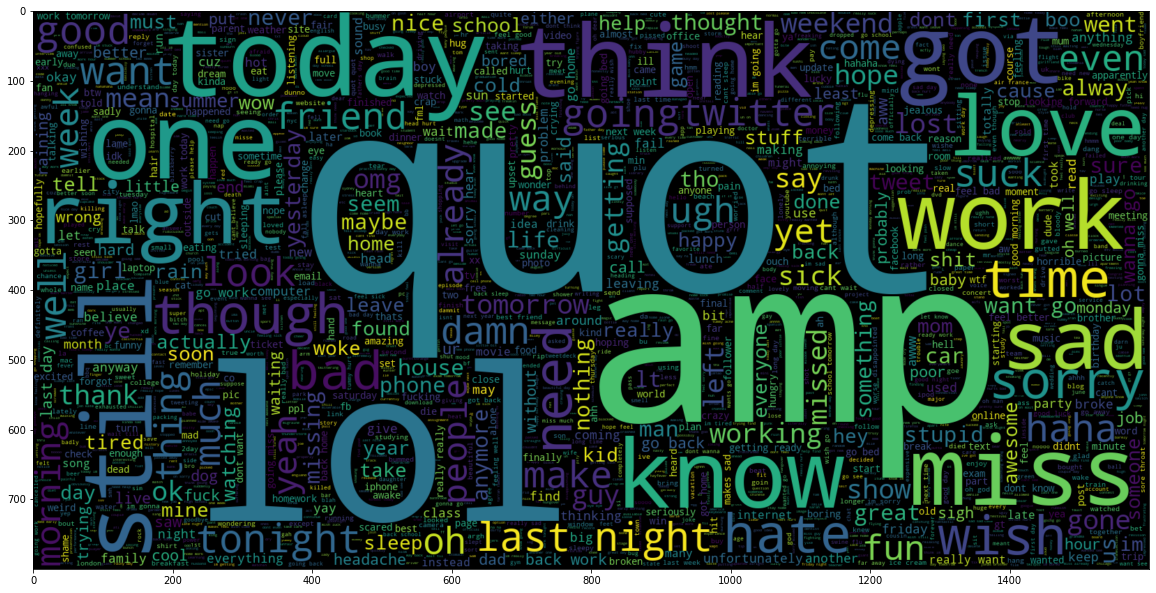

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.target == 'NEGATIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data=train_test_split(data,test_size=0.2,random_state=10)
print("Train Data size :- ",len(train_data))
print("Test Data size :- ",len(test_data))

Train Data size :-  1280000
Test Data size :-  320000


In [15]:
train_data.head()

,target,text
684663,NEGATIVE,yeah hmmmm laying low guess u ever wait till l...
1582042,POSITIVE,excited new everyday sunday cd released today ...
961181,POSITIVE,good morning tweeps tworld malibu strings biki...
296783,NEGATIVE,feeling sooo sick stressed exams tomorrow
13957,NEGATIVE,know feeling getting coworkers sick oh well th...


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index=tokenizer.word_index
vocab_size=len(tokenizer.word_index)+1
print("Vocabulary_Size :- ",vocab_size)

Vocabulary_Size :-  290429


In [17]:
MAX_SEQUENCE_LENGTH = 30
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Using TensorFlow backend.


Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [18]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [19]:
import tensorflow as tf
embedding_dim=300
max_length=30

model=tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.LSTM(100, dropout=0.2),
      tf.keras.layers.Dense(1,activation='sigmoid')
])



In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           87128700  
_________________________________________________________________
dropout (Dropout)            (None, 30, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,289,201
Trainable params: 87,289,201
Non-trainable params: 0
_________________________________________________________________


In [21]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy']
)

In [22]:
 history=model.fit(
    x_train,y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    verbose=1
)
model.save('tweetmodel.h5')

Epoch 1/10
1125/1125 [==============================] - 895s 796ms/step - loss: 0.5284 - accuracy: 0.7359 - val_loss: 0.4688 - val_accuracy: 0.7787
Epoch 2/10
1125/1125 [==============================] - 898s 798ms/step - loss: 0.4630 - accuracy: 0.7809 - val_loss: 0.4599 - val_accuracy: 0.7822
Epoch 3/10
1125/1125 [==============================] - 896s 796ms/step - loss: 0.4489 - accuracy: 0.7900 - val_loss: 0.4562 - val_accuracy: 0.7849
Epoch 4/10
1125/1125 [==============================] - 895s 796ms/step - loss: 0.4387 - accuracy: 0.7967 - val_loss: 0.4546 - val_accuracy: 0.7855
Epoch 5/10
1125/1125 [==============================] - 894s 795ms/step - loss: 0.4295 - accuracy: 0.8017 - val_loss: 0.4538 - val_accuracy: 0.7854
Epoch 6/10
1125/1125 [==============================] - 888s 790ms/step - loss: 0.4209 - accuracy: 0.8064 - val_loss: 0.4544 - val_accuracy: 0.7854
Epoch 7/10
1125/1125 [==============================] - 906s 806ms/step - loss: 0.4133 - accuracy: 0.8105 - val_

In [23]:
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 4s 14ms/step - loss: 0.4673 - accuracy: 0.7817

ACCURACY: 0.7816687226295471
LOSS: 0.46733734011650085


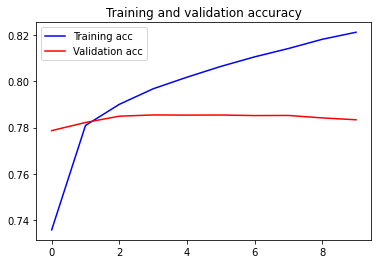

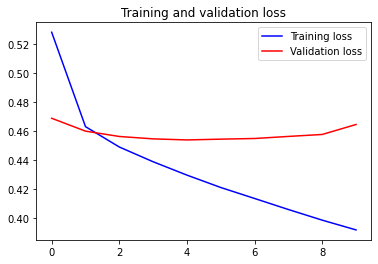

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [45]:
import time
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [46]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=30)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [47]:
predict("I love the music")

{'elapsed_time': 0.030055761337280273,
 'label': 'POSITIVE',
 'score': 0.9476331472396851}

In [48]:
predict("I hate the rain")

{'elapsed_time': 0.03511786460876465,
 'label': 'NEGATIVE',
 'score': 0.01966758631169796}

In [49]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.031616926193237305,
 'label': 'NEUTRAL',
 'score': 0.44366779923439026}